# COMP47490 Assignment 2

**Student Name** `Zhi Zhang` <br/>
**Student Number** `18210054` <br/>
**Dataset** `./census_18210054.csv`

## Import all required packages

In [1]:
import pandas as pd
import numpy as np
import time
from loguru import logger
from IPython.display import display, clear_output
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, balanced_accuracy_score, accuracy_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier

import gym
from gym import spaces
from gym.spaces import Discrete, MultiDiscrete
import numpy as np
import stable_baselines3 as sb3
import torch as th
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import DQN, PPO, A2C
from stable_baselines3.common.evaluation import evaluate_policy

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, InputLayer
from tensorflow.keras.optimizers import Adam
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

2022-12-04 18:13:17.118619: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# **Question 1** 
**Using dataset, perform the tasks below using Python and Scikit-learn.**

## **Question 1a** 
**Clean and prepare the dataset for machine learning analysis. You can do basic feature engineering to make your techniques scalable, but there is no need to go overboard with the dataset cleaning. Carefully consider the evaluation measure(s) that you use for this exercise and justify why you selected the particular evaluation measure(s). [10 marks]**

### Load the csv file

In [2]:
df = pd.read_csv('./census_18210054.csv')
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Income-category
0,23,Private,157127,Some-college,10,Never-married,Other-service,Not-in-family,White,Female,0,0,20,United-States,<=50K
1,62,Private,210935,HS-grad,9,Married-civ-spouse,Other-service,Husband,White,Male,0,0,20,United-States,<=50K
2,42,Private,337629,12th,8,Married-civ-spouse,Craft-repair,Husband,Black,Male,0,0,60,?,>50K
3,61,State-gov,162678,5th-6th,3,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K
4,46,Local-gov,172822,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K


### Check size of dataframe 
Show how many rows and columns this dataframe has.

In [3]:
print("This dataframe have %d rows & %d columns" % (df.shape[0],df.shape[1]))

This dataframe have 10000 rows & 15 columns


### Check spaces in dataframe
Sometimes, extra spaces or other characters may be included to affect subsequent operations.

In [4]:
df.columns

Index(['age', ' workclass', ' fnlwgt', ' education', ' education-num',
       ' marital-status', ' occupation', ' relationship', ' race', ' sex',
       ' capital-gain', ' capital-loss', ' hours-per-week', ' native-country',
       ' Income-category'],
      dtype='object')

From the above output we can see that there is a space at the beginning of each column name.<br/>
We use `.strip()` funtion in pandas to solve this issue.

In [5]:
df.rename(columns=lambda x:x.strip(),inplace=True)
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'Income-category'],
      dtype='object')

Remove space in front or back of all object type columns.

In [6]:
print("e.g Before: ",df.workclass.head().to_list())
for col in df.select_dtypes(["object"]):
    df[col] = df[col].str.strip()
print("e.g After: ",df.workclass.head().to_list())

e.g Before:  [' Private', ' Private', ' Private', ' State-gov', ' Local-gov']
e.g After:  ['Private', 'Private', 'Private', 'State-gov', 'Local-gov']


### Check data types in each column
Columns may have wrong data type.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              10000 non-null  int64 
 1   workclass        10000 non-null  object
 2   fnlwgt           10000 non-null  int64 
 3   education        10000 non-null  object
 4   education-num    10000 non-null  int64 
 5   marital-status   10000 non-null  object
 6   occupation       10000 non-null  object
 7   relationship     10000 non-null  object
 8   race             10000 non-null  object
 9   sex              10000 non-null  object
 10  capital-gain     10000 non-null  int64 
 11  capital-loss     10000 non-null  int64 
 12  hours-per-week   10000 non-null  int64 
 13  native-country   10000 non-null  object
 14  Income-category  10000 non-null  object
dtypes: int64(6), object(9)
memory usage: 1.1+ MB


In [8]:
#df['target_class'] = df['target_class'].astype('category')
df.dtypes

age                 int64
workclass          object
fnlwgt              int64
education          object
education-num       int64
marital-status     object
occupation         object
relationship       object
race               object
sex                object
capital-gain        int64
capital-loss        int64
hours-per-week      int64
native-country     object
Income-category    object
dtype: object

### Check descriptive stats for continuous features
We check the stats for these numeric columns.

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,10000.0,38.6284,13.611372,17.0,28.0,37.0,47.00,90.0
fnlwgt,10000.0,190902.6015,107064.819162,12285.0,118356.5,179568.0,238187.25,1484705.0
education-num,10000.0,10.0628,2.596985,1.0,9.0,10.0,12.00,16.0
capital-gain,10000.0,1100.8549,7595.948246,0.0,0.0,0.0,0.00,99999.0
capital-loss,10000.0,91.3614,409.960059,0.0,0.0,0.0,0.00,3900.0
hours-per-week,10000.0,40.3997,12.224422,1.0,40.0,40.0,45.00,99.0


### Check for duplicate row

In [10]:
#Print the number of duplicates, without the original rows that were duplicated
print('Number of duplicate (excluding first) rows in the table is: ', df.duplicated().sum())

# Check for duplicate rows. 
# Use "keep=False" to mark all duplicates as true, including the original rows that were duplicated.
print('Number of duplicate rows (including first) in the table is:', df[df.duplicated(keep=False)].shape[0])
df[df.duplicated(keep=False)]

Number of duplicate (excluding first) rows in the table is:  1
Number of duplicate rows (including first) in the table is: 2


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Income-category
4873,30,Private,144593,HS-grad,9,Never-married,Other-service,Not-in-family,Black,Male,0,0,40,?,<=50K
5436,30,Private,144593,HS-grad,9,Never-married,Other-service,Not-in-family,Black,Male,0,0,40,?,<=50K


Verify duplication

In [11]:
df.drop_duplicates(keep='first',inplace=True)
print('Number of duplicate (excluding first) rows in the table is: ', df.duplicated().sum())

Number of duplicate (excluding first) rows in the table is:  0


### Check Missing Values

In [12]:
df.isnull().sum()

age                0
workclass          0
fnlwgt             0
education          0
education-num      0
marital-status     0
occupation         0
relationship       0
race               0
sex                0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
Income-category    0
dtype: int64

Check if the missing value appears in another form

In [13]:
for col in df.select_dtypes(["object"]).columns:
    print(df[col].value_counts())

Private             6997
Self-emp-not-inc     752
Local-gov            679
?                    569
State-gov            376
Self-emp-inc         336
Federal-gov          286
Without-pay            4
Name: workclass, dtype: int64
HS-grad         3191
Some-college    2225
Bachelors       1610
Masters          525
Assoc-voc        437
11th             386
Assoc-acdm       329
10th             287
7th-8th          210
Prof-school      174
9th              160
Doctorate        147
12th             143
5th-6th          108
1st-4th           54
Preschool         13
Name: education, dtype: int64
Married-civ-spouse    4678
Never-married         3190
Divorced              1345
Separated              326
Widowed                312
Married-spouse-abs     140
Married-AF-spouse        8
Name: marital-status, dtype: int64
Prof-specialty       1255
Craft-repair         1248
Exec-managerial      1227
Adm-clerical         1163
Sales                1122
Other-service        1030
Machine-op-inspct     61

`workclass`, `occupation` and `native-country` contain `'?'` as Nan value.

### Checking the distribution of numerical features

In [14]:
for col in df.select_dtypes(["int64"]).columns:
    print(df[col].value_counts())

37    288
35    284
30    276
23    275
24    271
     ... 
83      3
84      3
88      1
85      1
86      1
Name: age, Length: 72, dtype: int64
164190    7
112497    6
200471    6
190290    6
99146     5
         ..
209899    1
340269    1
161259    1
219021    1
146879    1
Name: fnlwgt, Length: 8518, dtype: int64
9     3191
10    2225
13    1610
14     525
11     437
7      386
12     329
6      287
4      210
15     174
5      160
16     147
8      143
3      108
2       54
1       13
Name: education-num, dtype: int64
0        9169
15024      95
7688       88
7298       68
99999      52
         ... 
6360        1
2936        1
2387        1
6723        1
2009        1
Name: capital-gain, Length: 105, dtype: int64
0       9508
1902      60
1977      58
1887      53
1485      22
        ... 
2163       1
2489       1
3900       1
2457       1
1825       1
Name: capital-loss, Length: 73, dtype: int64
40    4690
50     864
45     565
60     483
35     429
      ... 
92       1
61    

We find `capital-gain` & `capital-loss` are unusual, the vast majority of them are "0". In addition, it's both belong to 'capital'. We could combine them and create a new column called `capital-current`.

### Check Features in plots

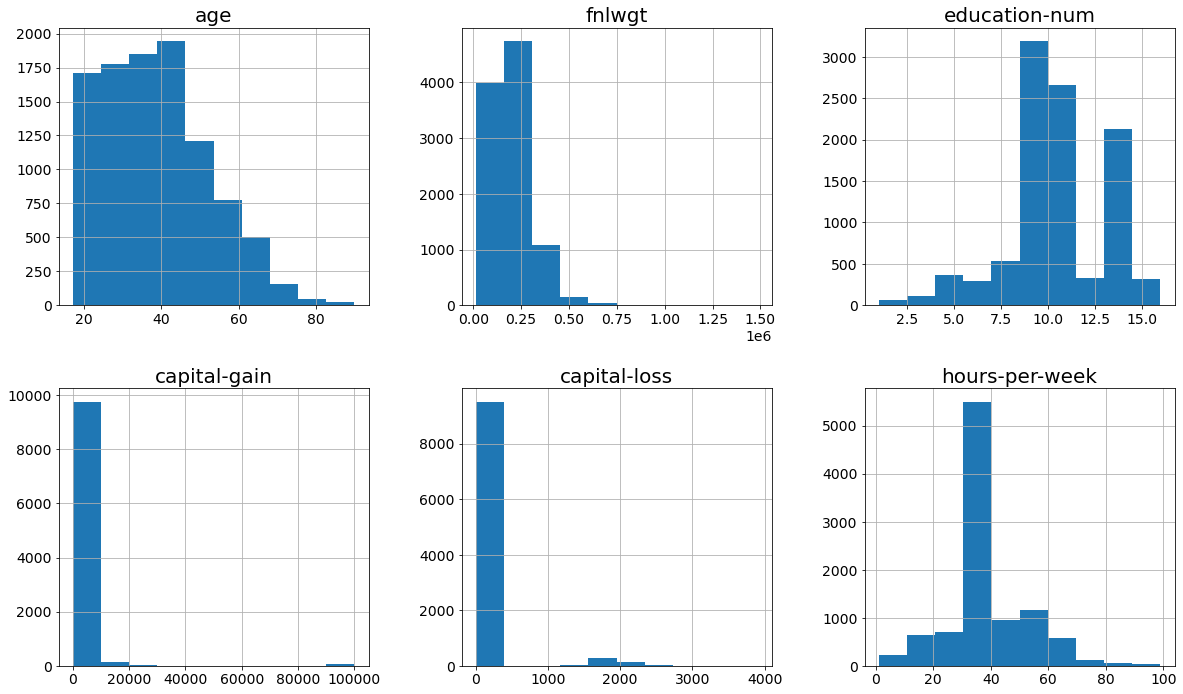

In [15]:
params = {'axes.titlesize':'20',
          'xtick.labelsize':'14',
          'ytick.labelsize':'14'}
matplotlib.rcParams.update(params)
df.hist(figsize=(20, 25), layout=(4,3));
plt.grid(visible=True, which='major', color='#666666', linestyle='-')

- Category column in **df**

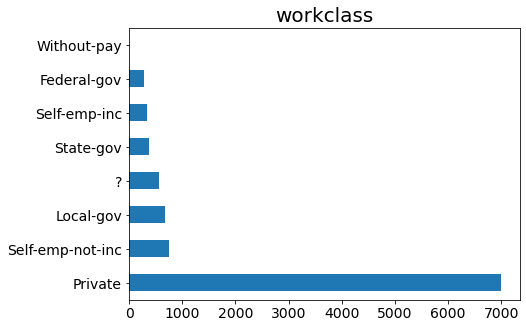

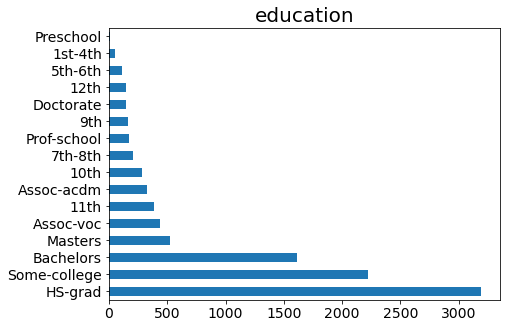

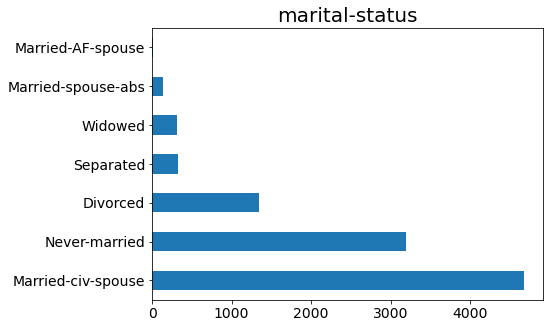

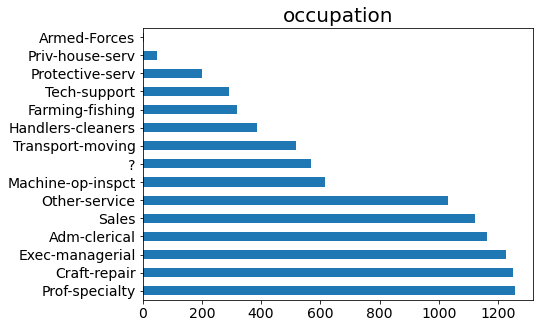

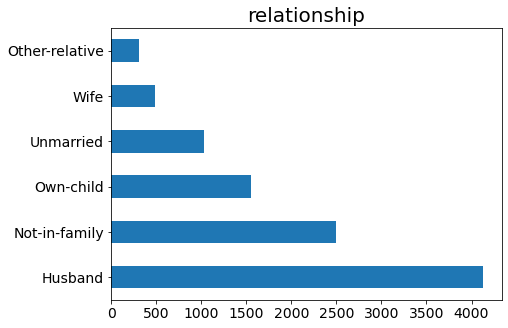

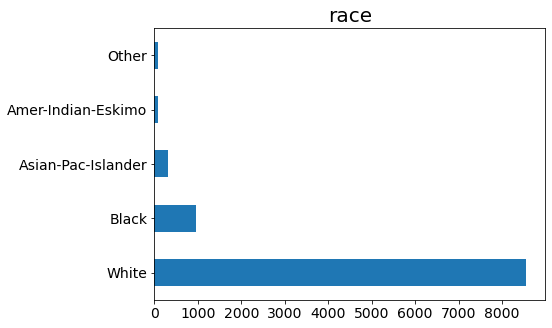

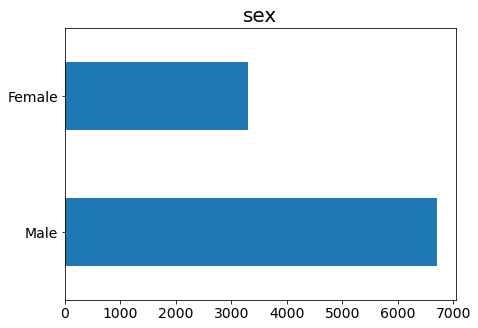

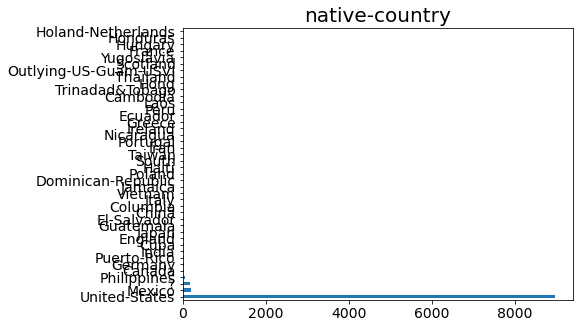

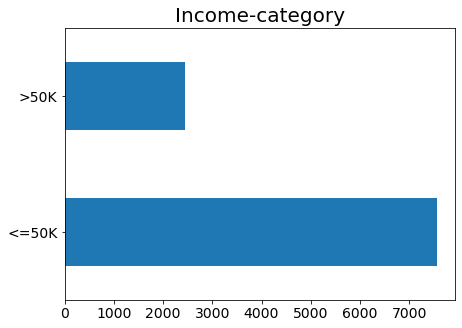

In [16]:
categorical_columns = df.select_dtypes(['object']).columns
for column in categorical_columns:
    
    df[column].value_counts(dropna=False).plot(kind='barh', title=column, figsize=(7,5),layout=(5, 2), rot=0)
    plt.show()

### Summary of the issues in data and potential handling strategies

| Feature         |Data Type| Data Quality Issue   | Handling Strategy      
|-----------------|---------|----------------------|------------------------
|age              |int64    | Need for normalisation | Normalize into 5 classes by encoding.
|workclass        |object   | Contain missing value <br/> Wrong data type | Missing value in `?` format, drop it. <br/>Change to `category` type.
|fnlwgt           |int64    | Irrelevant data      | Drop it.
|education        |object   | Duplicated column    | Drop it.
|education-num    |int64    | Wrong data type      | Rename as `education` and change to `category` type.
|marital-status   |object   | Wrong data type      | Change to `category` type.
|occupation       |object   | Contain missing value <br/> Wrong data type | Missing value in `?` format, drop it. <br/>Change to `category` type.
|relationship     |object   | Wrong data type      | Change to `category` type.
|race             |object   | Wrong data type      | Change to `category` type.
|sex              |object   | Wrong data type      | Change to `category` type.
|capital-gain     |int64    | Imbalanced data (1) <br/> & High Outliers | Combine (1) & (2) as new column `capital-current`. <br/> Clamp high outliers to the 95th percentile.
|capital-loss     |int64    | Imbalanced data (2) | See above.
|hours-per-week   |int64    | Need for normalisation | Normalize into 5 classes by encoding.
|native-country   |object   | Contain missing value <br/> Wrong data type <br/> Imbalanced data| Missing value in `?` format, drop it. <br/>Change to `category` type & Binary Encoding.
|Income-category  |object   | Wrong data type      | Change to `category` type.

### Clean the data using the strategies

Store a copy of the training and test data before filling in the missing values.

In [17]:
df_copy = df.copy()

In [18]:
df = df_copy.copy()

#### **Handel Missing Value**
Drop rows if contain `?`

In [19]:
df_clean = df.replace("?", np.nan).dropna()
df_clean.shape

(9264, 15)

Check missing value again

In [20]:
df_clean.isnull().sum().sum()

0

#### **Concat columns**
Use `capital-gain` - `capital-loss` we get new column called `capital-current`


In [21]:
df_clean['capital-current'] = df_clean['capital-gain'] - df_clean['capital-loss']

#### **Drop Columns**

In [22]:
df_clean.drop(columns=['fnlwgt','education','capital-gain','capital-loss'], inplace=True)

Rename column

In [23]:
df_clean.rename(columns={'education-num': 'education'}, inplace=True)

#### **Data Normalisation**

***Normalize into 5 classes by encoding***

For `age` and `hours-per-week`

In [24]:
def encode_by_5_bin(in_put):
    if in_put <= 20:
        return 'under20'
    elif in_put <= 40:
        return '20_40'
    elif in_put <= 60:
        return '40_60'
    elif in_put <= 80:
        return '60_80'
    else:
        return 'over_80'
    
def encode_by_3_bin(in_put):
    if in_put < 0:
        return 'Negative'
    elif in_put == 0:
        return 'Unchanged'
    else:
        return 'Positive'
    
cols = ['age','hours-per-week']

for col in cols:
    df_clean[col] = df_clean.apply(lambda x: encode_by_5_bin(x[col]), axis=1)
    print(df_clean[col].value_counts(),'\n')

df_clean['capital-current'] = df_clean.apply(lambda x: encode_by_3_bin(x['capital-current']), axis=1)
print(df_clean['capital-current'].value_counts())

20_40      4839
40_60      3275
under20     578
60_80       548
over_80      24
Name: age, dtype: int64 

20_40      5749
40_60      2515
under20     699
60_80       248
over_80      53
Name: hours-per-week, dtype: int64 

Unchanged    8044
Positive      764
Negative      456
Name: capital-current, dtype: int64


***Normalize `native-country` into 2 main class, 'US' & 'Non-US'***

In [25]:
df_clean['native-country'] = df_clean['native-country'].apply(lambda x: 'US' if x == 'United-States' else 'Non-US')
df_clean['native-country'].value_counts()

US        8432
Non-US     832
Name: native-country, dtype: int64

In [26]:
label = LabelEncoder()
for cols in df_clean.columns:
    df_clean[cols] = label.fit_transform(df_clean[cols])
    #df_clean[col] = df_clean[[col]].apply(lambda x: label.fit_transform(x))
    #df_clean[col] = df_clean[col].astype('category')

In [27]:
cols = df_clean.columns
df_clean[cols] = df_clean[cols].apply(lambda x: x.astype('category'))
df_clean.dtypes

age                category
workclass          category
education          category
marital-status     category
occupation         category
relationship       category
race               category
sex                category
hours-per-week     category
native-country     category
Income-category    category
capital-current    category
dtype: object

In [28]:
print("After clean, this dataframe have %d rows & %d columns" % (df_clean.shape[0],df_clean.shape[1]))
df_clean.reset_index(drop=True, inplace=True)
df_clean.info()

After clean, this dataframe have 9264 rows & 12 columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9264 entries, 0 to 9263
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   age              9264 non-null   category
 1   workclass        9264 non-null   category
 2   education        9264 non-null   category
 3   marital-status   9264 non-null   category
 4   occupation       9264 non-null   category
 5   relationship     9264 non-null   category
 6   race             9264 non-null   category
 7   sex              9264 non-null   category
 8   hours-per-week   9264 non-null   category
 9   native-country   9264 non-null   category
 10  Income-category  9264 non-null   category
 11  capital-current  9264 non-null   category
dtypes: category(12)
memory usage: 112.0 KB


### Split training set (70%) and test set (30%) **ahead**

To avoid **Data Leakage**, we must split the dataset into train and test sets, with the training data used only for feature selection and model fitting. The test set will be utilised exclusively for evaluation and not for model training.

In [29]:
y = df_clean['Income-category']
x = df_clean.drop(columns = ['Income-category'])

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
print("Training set size is %d\nTest set size is %d" % (X_train.shape[0], X_test.shape[0]))

Training set size is 6484
Test set size is 2780


Compare Proportion of `Income-category` in original df and split set.

In [30]:
print("Original:\n",df_clean['Income-category'].value_counts()/df_clean['Income-category'].shape[0],
      "\n\nTrain:\n",y_train.value_counts()/y_train.shape[0],
      "\n\nTest:\n",y_test.value_counts()/y_test.shape[0])

Original:
 0    0.749244
1    0.250756
Name: Income-category, dtype: float64 

Train:
 0    0.751542
1    0.248458
Name: Income-category, dtype: float64 

Test:
 0    0.743885
1    0.256115
Name: Income-category, dtype: float64


The ratio change of the two target classes after separation is `less than 0.01%`, which is an acceptable range.

### Decide the best evaluation measure

Accuracy: 0.813
Accuracy of the dummy classifier: 0.744
Precision score: 0.727
Recall score: 0.431
Macro-averaged F1 score: 0.712


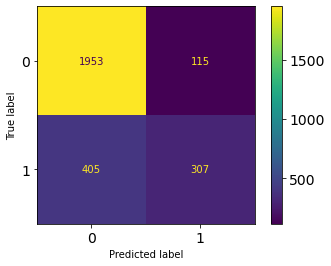

In [31]:
classifier = SVC(random_state=1)
classifier.fit(X_train, np.ravel(y_train))
y_predicted = classifier.predict(X_test)
ConfusionMatrixDisplay.from_estimator(classifier, X_test, y_test);

accuracy = accuracy_score(y_test, y_predicted)
precision = precision_score(y_test, y_predicted, pos_label=1)
recall = recall_score(y_test, y_predicted, pos_label=1)

dummy_classifier = DummyClassifier(strategy="most_frequent")
dummy_classifier.fit(X_train, y_train)
balanced_accuracy = balanced_accuracy_score(y_test, y_predicted)

print(f"Accuracy: {accuracy:.3f}")
print(f"Accuracy of the dummy classifier: " f"{dummy_classifier.score(X_test, y_test):.3f}")
print(f"Precision score: {precision:.3f}")
print(f"Recall score: {recall:.3f}")
print(f"Macro-averaged F1 score: {f1_score(y_test, y_predicted, average='macro'):.3f}")

The above clearly shows that our data set is highly unbalanced. The vast majority of the target classes are `<=50K` (label in '0') have 1953 and only 307 records are classified as `>50K` (label in '1'). Even through the accuracy can still be a useful metric when the class distribution is slightly skewed. However, when there is a significant skew in the class distributions, accuracy might become an unreliable metric of model performance. We acquire a **Macro-averaged F1-score** of `71.2%` which is computed using the arithmetic mean (unweighted mean) of all the per-class F1 scores. This method treats all classes equally regardless of their support values. And it is suitable for usage in this highly unbalanced target class of dataset. We acquire an accuracy score of 74.4% using the dummy classifier which always predicts the positive class of simulation success. 

As a result, we can substitute the **Macro-averaged F1-score** for accuracy.

## **Question 1b** 
**Evaluate the performance of three basic classifiers on your dataset: a decision tree with depth at most 3, a neural network with at most 10 hidden nodes and 1-NN. You can do basic parameter tuning, but there is no need to go overboard. The goal in this step is simply to create better than random classifiers. [5 marks]**

### Decision Tree (with depth at most 3)

In [32]:
result = {}
full_result = {}
for depth in range(2, 4):
    for samples_in_leaf in [1, 2, 3, 5, 10]:
        clear_output()
        logger.info("Max depth = {}".format(depth))
        logger.info('Min samples leaf = {}'.format(samples_in_leaf))
        dtc = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=samples_in_leaf, random_state=1) 
        # Fit the decision trees model on the training data.
        dtc.fit(X_train, y_train)

        # Predict on the training dataset.
        y_predicted = dtc.predict(X_train)
        logger.info('Prediction performance on training set: {}'.format(f1_score(y_train, y_predicted, average='macro')))

        # Predict on the test data.
        y_predicted = dtc.predict(X_test)
        
        score = f1_score(y_test, y_predicted, average='macro')
        result[(depth,samples_in_leaf)] = score
        logger.info('Prediction performance on testing set: {}'.format(score))

#accuracy_rank = dict(sorted(result.items(), key=lambda x: x[1], reverse=True))
top = sorted(result.items(), key=lambda x: x[1], reverse=True)[0]
print("\n--------------------------------------------------------------")
print("The Best Decision Trees Classifier is: \nMax depth = ",top[0][0],"\nMin samples leaf = %d \nwith Macro F1-score = %f." % (top[0][1],top[1]))
# Use best parameter train again
dtc = DecisionTreeClassifier(max_depth=top[0][0], min_samples_leaf=top[0][1], random_state=1).fit(X_train, y_train)
full_result['dtc'] = top[1]

2022-12-04 18:13:29.970 | INFO     | __main__:<module>:6 - Max depth = 3
2022-12-04 18:13:29.970 | INFO     | __main__:<module>:7 - Min samples leaf = 10
2022-12-04 18:13:29.983 | INFO     | __main__:<module>:14 - Prediction performance on training set: 0.7128890273725256
2022-12-04 18:13:29.989 | INFO     | __main__:<module>:21 - Prediction performance on testing set: 0.7083733334636966



--------------------------------------------------------------
The Best Decision Trees Classifier is: 
Max depth =  3 
Min samples leaf = 1 
with Macro F1-score = 0.708373.


### Neural Network (with at most 10 hidden nodes)

In [33]:
result = {}
for hls in [(1,),(2,),(3,),(4,),(5,),(6,),(7,),(8,),(9,),(10,)]:
    for act in ['logistic', 'tanh', 'relu']:
        for sol in ['lbfgs', 'sgd', 'adam']:
            clear_output()
            logger.info('hidden_layer_sizes = {}'.format(hls)) 
            logger.info('activation = {}'.format(act))
            logger.info('solver = {}'.format(sol))
            mlp = MLPClassifier(hidden_layer_sizes=hls, activation=act, max_iter=10, alpha=1e-4, solver=sol, 
                                verbose=1, random_state=1, learning_rate_init=.1)
            # Fit the decision trees model on the training data.
            mlp.fit(X_train, y_train)

            # Predict on the training dataset.
            y_predicted = mlp.predict(X_train)
            logger.info('Prediction performance on training set: {}'.format(f1_score(y_train, y_predicted, average='macro')))

            # Predict on the test data.
            y_predicted = mlp.predict(X_test)

            score = f1_score(y_test, y_predicted, average='macro')
            result[(sol,act,hls)] = score
            logger.info('Prediction performance on testing set: {}'.format(score))

#accuracy_rank = dict(sorted(result.items(), key=lambda x: x[1], reverse=True))
top = sorted(result.items(), key=lambda x: x[1], reverse=True)[0]
print("\n--------------------------------------------------------------")
print("The Best Neural Network is: \nHidden layer sizes = ",top[0][2],"\nActivation = %s \nSolver = %s \nwith Macro F1-score = %f." % (top[0][1],top[0][0],top[1]))
print("--------------------------------------------------------------\n")
# Use best parameter train again
mlp = MLPClassifier(hidden_layer_sizes=top[0][2], activation=top[0][1], max_iter=10, alpha=1e-4, 
                    solver=top[0][0], verbose=1, random_state=1, learning_rate_init=.1).fit(X_train, y_train);
full_result['mlp'] = top[1]

2022-12-04 18:13:39.215 | INFO     | __main__:<module>:6 - hidden_layer_sizes = (10,)
2022-12-04 18:13:39.216 | INFO     | __main__:<module>:7 - activation = relu
2022-12-04 18:13:39.216 | INFO     | __main__:<module>:8 - solver = adam


Iteration 1, loss = 0.55978025
Iteration 2, loss = 0.41623505
Iteration 3, loss = 0.39768601
Iteration 4, loss = 0.39481900
Iteration 5, loss = 0.39482411
Iteration 6, loss = 0.38653498
Iteration 7, loss = 0.38655848


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
2022-12-04 18:13:39.358 | INFO     | __main__:<module>:16 - Prediction performance on training set: 0.7682794601790777
2022-12-04 18:13:39.364 | INFO     | __main__:<module>:23 - Prediction performance on testing set: 0.7475950625824164


Iteration 8, loss = 0.38412858
Iteration 9, loss = 0.37492232
Iteration 10, loss = 0.38544356

--------------------------------------------------------------
The Best Neural Network is: 
Hidden layer sizes =  (10,) 
Activation = relu 
Solver = adam 
with Macro F1-score = 0.747595.
--------------------------------------------------------------

Iteration 1, loss = 0.55978025
Iteration 2, loss = 0.41623505
Iteration 3, loss = 0.39768601
Iteration 4, loss = 0.39481900
Iteration 5, loss = 0.39482411
Iteration 6, loss = 0.38653498
Iteration 7, loss = 0.38655848
Iteration 8, loss = 0.38412858
Iteration 9, loss = 0.37492232
Iteration 10, loss = 0.38544356


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


### K-Nearest Neighbours (with neighbour=1)

In [34]:
knn = KNeighborsClassifier(n_neighbors=1) 
# Fit the KNN model on the credit risk training data
knn.fit(X_train, y_train)

# Predict on the training dataset
y_predicted = knn.predict(X_train)
print('Prediction performance on training set: {}'.format(f1_score(y_train, y_predicted, average='macro')))

# Predict on the test data using the trained KNN mode
y_predicted = knn.predict(X_test)

score = f1_score(y_test, y_predicted, average='macro')
print('Prediction performance on testing set: {}'.format(score))
print("\n--------------------------------------------------------------")
print("The F1 score of KNN Classifier with n_neighbors=1 is {}".format(score))
full_result['knn'] = score

Prediction performance on training set: 0.8869475704537719
Prediction performance on testing set: 0.6910626967404624

--------------------------------------------------------------
The F1 score of KNN Classifier with n_neighbors=1 is 0.6910626967404624


### Compare the different classifiers

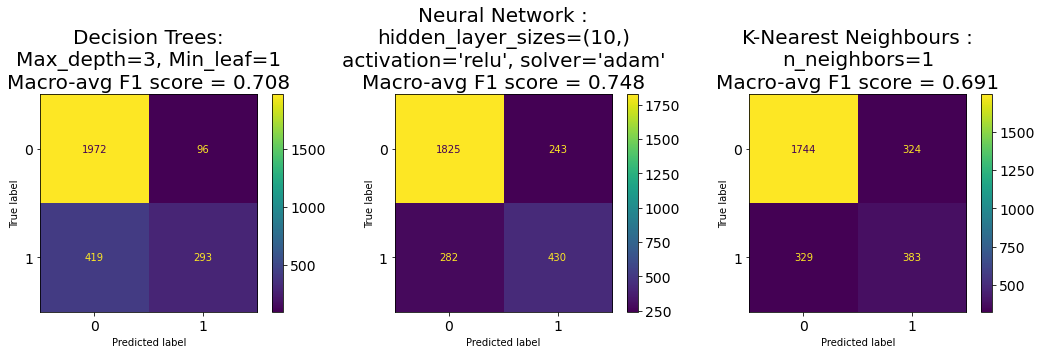

In [35]:
fig, ax = plt.subplots(1, 3, figsize=(18, 4))
ConfusionMatrixDisplay.from_estimator(dtc, X_test, y_test, ax=ax[0])\
    .ax_.set_title("Decision Trees:\nMax_depth=3, Min_leaf=1\nMacro-avg F1 score = {:.3f}".format(full_result['dtc']))
ConfusionMatrixDisplay.from_estimator(mlp, X_test, y_test, ax=ax[1])\
    .ax_.set_title("Neural Network :\nhidden_layer_sizes=(10,)\nactivation=\'relu\', solver=\'adam\'\nMacro-avg F1 score = {:.3f}".format(full_result['mlp']))
ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test, ax=ax[2])\
    .ax_.set_title("K-Nearest Neighbours :\nn_neighbors=1\nMacro-avg F1 score = {:.3f}".format(full_result['knn']))
clear_output()
plt.show();

<br/>**Insight**

From the results above we can see that Neural network with hidden_layer_sizes=(10,) is the best classifier (0.748) followed by decision tree with 0.708. The worst is KNN (n_neighbors=1) which have 0.691 macro-averaged F1 score. All basic classifiers above are better than random. What surprised me most was that Neural network has excellent performance and it comes first in most cases in this comparison.

## **Question 1c** 
**Apply ensembles with bagging using the three classifiers from Task (b). Investigate the performance of each of these classifiers as the ensemble size increases (e.g., in steps of 2 from 2 to 20 members). Using the best performing ensemble size, investigate how changing the number of instances in the bootstrap samples affects classification performance. [10 marks]**

### Decision Tree

In [36]:
def best_ensemble_size(classifier, ensemble_size, X_train, X_test, y_train, y_test):
    result = {}
    for e_size in ensemble_size:
        bag = BaggingClassifier(classifier, n_estimators = e_size, bootstrap = True, random_state=1)
        bag.fit(X_train, y_train)
        pred = bag.predict(X_test)
        scores_bag = f1_score(y_test, pred, average='macro')
        clear_output()
        logger.info("n_estimators={}".format(e_size))
        logger.info("Average F1-score for {} is {:.5f}".format(classifier.__class__.__name__+'_bag',scores_bag))
        result[e_size] = scores_bag

    # Accuracy rank
    return sorted(result.items(), key=lambda x: x[1], reverse=True)[0]

ensemble_size = range(2, 21, 2)
result = best_ensemble_size(dtc, ensemble_size, X_train, X_test, y_train, y_test)
print("[Decision Tree] The Best ensemble size is {} with macro-averaged f1-score {:.5f}".format(result[0],result[1]))

2022-12-04 18:13:40.912 | INFO     | __main__:best_ensemble_size:9 - n_estimators=20
2022-12-04 18:13:40.913 | INFO     | __main__:best_ensemble_size:10 - Average F1-score for DecisionTreeClassifier_bag is 0.71674


[Decision Tree] The Best ensemble size is 8 with macro-averaged f1-score 0.73763


In [37]:
def best_num_instances(classifier, ensemble_size, num_instances, X_train, X_test, y_train, y_test):
    result = {}
    for instance in num_instances:
        bag = BaggingClassifier(classifier, n_estimators = ensemble_size, max_samples = instance, 
                                bootstrap = True, random_state=1)
        bag.fit(X_train, y_train)
        pred = bag.predict(X_test)
        scores_bag = f1_score(y_test, pred, average='macro')
        clear_output()
        logger.info("max_samples={}".format(instance))
        logger.info("Average F1-score for {} is {:.5f}".format(classifier.__class__.__name__+'_bag',scores_bag))
        result[instance] = scores_bag
    
    # Accuracy rank, Bag estimators num, Best bag
    rank = sorted(result.items(), key=lambda x: x[1], reverse=True)[0]
    best_bag = BaggingClassifier(classifier, n_estimators = ensemble_size, max_samples = rank[0], 
                                bootstrap = True, random_state=1).fit(X_train, y_train)
    return (rank, bag.n_estimators, best_bag);

num_instances = [0.25, 0.5, 0.75, 1.0]
rank, num, best_dtcBag = best_num_instances(dtc, 8, num_instances, X_train, X_test, y_train, y_test)
full_result['dtc_bag'] = rank[1]
print("[Decision Tree] The Best max_samples is {} with ensemble_size={} and macro-averaged f1-score {:.5f}".format(rank[0], num, rank[1]))

2022-12-04 18:13:41.065 | INFO     | __main__:best_num_instances:10 - max_samples=1.0
2022-12-04 18:13:41.065 | INFO     | __main__:best_num_instances:11 - Average F1-score for DecisionTreeClassifier_bag is 0.73763


[Decision Tree] The Best max_samples is 1.0 with ensemble_size=8 and macro-averaged f1-score 0.73763


### Neural Network

In [38]:
ensemble_size = range(2, 21, 2)
result = best_ensemble_size(mlp, ensemble_size, X_train, X_test, y_train, y_test)
print("[Neural Network] The Best ensemble size is {} with macro-average f1-score {:.5f}".format(result[0],result[1]))

2022-12-04 18:13:53.782 | INFO     | __main__:best_ensemble_size:9 - n_estimators=20
2022-12-04 18:13:53.783 | INFO     | __main__:best_ensemble_size:10 - Average F1-score for MLPClassifier_bag is 0.72645


[Neural Network] The Best ensemble size is 20 with macro-average f1-score 0.72645


In [39]:
num_instances = [0.25, 0.5, 0.75, 1.0]
rank, num, best_mlpBag = best_num_instances(mlp, 20, num_instances, X_train, X_test, y_train, y_test)
full_result['mlp_bag'] = rank[1]
print("[Neural Network] The Best number of instance is {} with ensemble_size={} and macro-average f1-score {:.5f}".format(rank[0], num, rank[1]))

2022-12-04 18:13:59.784 | INFO     | __main__:best_num_instances:10 - max_samples=1.0
2022-12-04 18:13:59.785 | INFO     | __main__:best_num_instances:11 - Average F1-score for MLPClassifier_bag is 0.72645


Iteration 1, loss = 0.75349977
Iteration 2, loss = 0.46182943
Iteration 3, loss = 0.44811896
Iteration 4, loss = 0.44144187
Iteration 5, loss = 0.44328468
Iteration 6, loss = 0.43671772
Iteration 7, loss = 0.43383538
Iteration 8, loss = 0.41585343
Iteration 9, loss = 0.40904204
Iteration 10, loss = 0.40725553


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.50156378
Iteration 2, loss = 0.46633360
Iteration 3, loss = 0.44816615
Iteration 4, loss = 0.44617943
Iteration 5, loss = 0.44426788
Iteration 6, loss = 0.44783014
Iteration 7, loss = 0.44588426
Iteration 8, loss = 0.45518311
Iteration 9, loss = 0.44372021
Iteration 10, loss = 0.44583342
Iteration 1, loss = 0.51348744
Iteration 2, loss = 0.40951304
Iteration 3, loss = 0.38370577


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.37641532
Iteration 5, loss = 0.38839540
Iteration 6, loss = 0.37263547
Iteration 7, loss = 0.37441281
Iteration 8, loss = 0.39423484
Iteration 9, loss = 0.37670495
Iteration 10, loss = 0.37625947
Iteration 1, loss = 0.68445307
Iteration 2, loss = 0.45396246
Iteration 3, loss = 0.44778420
Iteration 4, loss = 0.43673049
Iteration 5, loss = 0.43059203
Iteration 6, loss = 0.42903671
Iteration 7, loss = 0.42936225
Iteration 8, loss = 0.43092051


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 9, loss = 0.43476918
Iteration 10, loss = 0.43151774
Iteration 1, loss = 0.73461169
Iteration 2, loss = 0.43414060
Iteration 3, loss = 0.41497982
Iteration 4, loss = 0.41009178
Iteration 5, loss = 0.38968110
Iteration 6, loss = 0.40184694
Iteration 7, loss = 0.39627377
Iteration 8, loss = 0.38923995


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 9, loss = 0.39698993
Iteration 10, loss = 0.38739295
Iteration 1, loss = 0.77749049
Iteration 2, loss = 0.47812036
Iteration 3, loss = 0.44125150
Iteration 4, loss = 0.42313899
Iteration 5, loss = 0.40600033
Iteration 6, loss = 0.39588750
Iteration 7, loss = 0.39483248


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 8, loss = 0.39595513
Iteration 9, loss = 0.39306215
Iteration 10, loss = 0.38542270
Iteration 1, loss = 0.70843331
Iteration 2, loss = 0.47479887
Iteration 3, loss = 0.45109248
Iteration 4, loss = 0.44639617
Iteration 5, loss = 0.44766065
Iteration 6, loss = 0.44180626
Iteration 7, loss = 0.44038519


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 8, loss = 0.43503477
Iteration 9, loss = 0.43758439
Iteration 10, loss = 0.44758426
Iteration 1, loss = 0.50986944
Iteration 2, loss = 0.44299217
Iteration 3, loss = 0.41312230
Iteration 4, loss = 0.40515456
Iteration 5, loss = 0.39430323


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 6, loss = 0.38900550
Iteration 7, loss = 0.38469052
Iteration 8, loss = 0.37939163
Iteration 9, loss = 0.38536339
Iteration 10, loss = 0.37877177
Iteration 1, loss = 0.50298637
Iteration 2, loss = 0.42720658
Iteration 3, loss = 0.41235456
Iteration 4, loss = 0.40208622
Iteration 5, loss = 0.39832458
Iteration 6, loss = 0.39030848


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 7, loss = 0.38549170
Iteration 8, loss = 0.38806234
Iteration 9, loss = 0.38902829
Iteration 10, loss = 0.37559995
Iteration 1, loss = 0.93947044
Iteration 2, loss = 0.50445498
Iteration 3, loss = 0.46293679


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.43590773
Iteration 5, loss = 0.41951511
Iteration 6, loss = 0.40697615
Iteration 7, loss = 0.40276915
Iteration 8, loss = 0.41238603
Iteration 9, loss = 0.42007859
Iteration 10, loss = 0.40424621
Iteration 1, loss = 0.62793493
Iteration 2, loss = 0.48091204
Iteration 3, loss = 0.44732018
Iteration 4, loss = 0.43240764
Iteration 5, loss = 0.41719616


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 6, loss = 0.41474900
Iteration 7, loss = 0.39318440
Iteration 8, loss = 0.39620178
Iteration 9, loss = 0.38303256
Iteration 10, loss = 0.37807120
Iteration 1, loss = 0.59128005
Iteration 2, loss = 0.44247762


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.42647283
Iteration 4, loss = 0.41028962
Iteration 5, loss = 0.39255504
Iteration 6, loss = 0.40237418
Iteration 7, loss = 0.39867242
Iteration 8, loss = 0.39397963
Iteration 9, loss = 0.38766987
Iteration 10, loss = 0.38440356
Iteration 1, loss = 0.53348164
Iteration 2, loss = 0.41520329
Iteration 3, loss = 0.39365846
Iteration 4, loss = 0.38455378


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.37671038
Iteration 6, loss = 0.36781533
Iteration 7, loss = 0.38133300
Iteration 8, loss = 0.37172500
Iteration 9, loss = 0.36186601
Iteration 10, loss = 0.37396873
Iteration 1, loss = 0.74527126
Iteration 2, loss = 0.46030138
Iteration 3, loss = 0.42372035
Iteration 4, loss = 0.42141106
Iteration 5, loss = 0.42317198
Iteration 6, loss = 0.42223117
Iteration 7, loss = 0.40975502
Iteration 8, loss = 0.40599665
Iteration 9, loss = 0.39624366


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 10, loss = 0.38923261
Iteration 1, loss = 0.68015135
Iteration 2, loss = 0.45364418
Iteration 3, loss = 0.43799270
Iteration 4, loss = 0.42325025


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.40956400
Iteration 6, loss = 0.40490500
Iteration 7, loss = 0.40447079
Iteration 8, loss = 0.39559718
Iteration 9, loss = 0.38952513
Iteration 10, loss = 0.39246873
Iteration 1, loss = 0.63700583
Iteration 2, loss = 0.44436337
Iteration 3, loss = 0.43706729
Iteration 4, loss = 0.43099760
Iteration 5, loss = 0.43086130
Iteration 6, loss = 0.40679178
Iteration 7, loss = 0.39340033
Iteration 8, loss = 0.38839781


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 9, loss = 0.38789320
Iteration 10, loss = 0.38677808
Iteration 1, loss = 0.61224638
Iteration 2, loss = 0.45104765
Iteration 3, loss = 0.42949783


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.41169191
Iteration 5, loss = 0.40025564
Iteration 6, loss = 0.39320819
Iteration 7, loss = 0.40818733
Iteration 8, loss = 0.39451730
Iteration 9, loss = 0.38728852
Iteration 10, loss = 0.38653529
Iteration 1, loss = 0.47144118
Iteration 2, loss = 0.42229295
Iteration 3, loss = 0.40960197
Iteration 4, loss = 0.40672871
Iteration 5, loss = 0.38809278
Iteration 6, loss = 0.40378674
Iteration 7, loss = 0.40986581
Iteration 8, loss = 0.39221143
Iteration 9, loss = 0.38144855


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 10, loss = 0.38074668
Iteration 1, loss = 0.67231495
Iteration 2, loss = 0.47737563
Iteration 3, loss = 0.44305801


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.43486566
Iteration 5, loss = 0.41538732
Iteration 6, loss = 0.41358608
Iteration 7, loss = 0.40816248
Iteration 8, loss = 0.40563488
Iteration 9, loss = 0.40789903
Iteration 10, loss = 0.40247198
Iteration 1, loss = 0.78721685
Iteration 2, loss = 0.48324866
Iteration 3, loss = 0.45789607
Iteration 4, loss = 0.45507912
Iteration 5, loss = 0.44098876
Iteration 6, loss = 0.43238155
Iteration 7, loss = 0.43322961
Iteration 8, loss = 0.44363100
Iteration 9, loss = 0.43304644


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 10, loss = 0.41336728
[Neural Network] The Best number of instance is 1.0 with ensemble_size=20 and macro-average f1-score 0.72645


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


### K-Nearest Neighbours

In [40]:
ensemble_size = range(2, 21, 2)
result = best_ensemble_size(knn, ensemble_size, X_train, X_test, y_train, y_test)
print("[K-Nearest Neighbours] The Best ensemble size is {} with macro-averaged f1-score {:.5f}".format(result[0],result[1]))

2022-12-04 18:14:07.331 | INFO     | __main__:best_ensemble_size:9 - n_estimators=20
2022-12-04 18:14:07.331 | INFO     | __main__:best_ensemble_size:10 - Average F1-score for KNeighborsClassifier_bag is 0.73918


[K-Nearest Neighbours] The Best ensemble size is 14 with macro-averaged f1-score 0.73944


In [41]:
num_instances = [0.25, 0.5, 0.75, 1.0]
rank, num, best_knnBag = best_num_instances(knn, 14, num_instances, X_train, X_test, y_train, y_test)
full_result['knn_bag'] = rank[1]
print("[K-Nearest Neighbours] The Best number of instance is {} with ensemble_size={} and macro-averaged f1-score {:.5f}".format(rank[0], num, rank[1]))

2022-12-04 18:14:09.461 | INFO     | __main__:best_num_instances:10 - max_samples=1.0
2022-12-04 18:14:09.462 | INFO     | __main__:best_num_instances:11 - Average F1-score for KNeighborsClassifier_bag is 0.73944


[K-Nearest Neighbours] The Best number of instance is 1.0 with ensemble_size=14 and macro-averaged f1-score 0.73944


### Compare the different classifiers

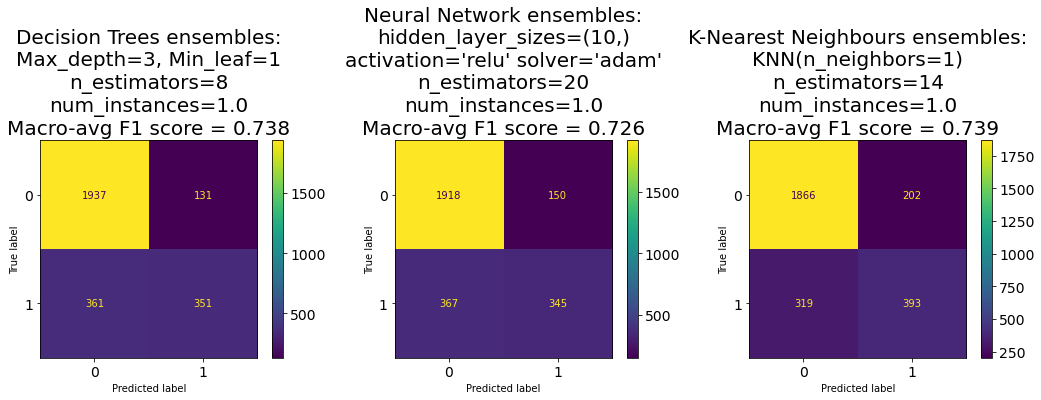

In [42]:
fig, ax = plt.subplots(1, 3, figsize=(18, 4))
ConfusionMatrixDisplay.from_estimator(best_dtcBag, X_test, y_test, ax=ax[0])\
    .ax_.set_title("Decision Trees ensembles:\nMax_depth=3, Min_leaf=1\nn_estimators={}\nnum_instances={}\nMacro-avg F1 score = {:.3f}"
                   .format(best_dtcBag.n_estimators, best_dtcBag.max_samples, full_result['dtc_bag']))
ConfusionMatrixDisplay.from_estimator(best_mlpBag, X_test, y_test, ax=ax[1])\
    .ax_.set_title("Neural Network ensembles:\nhidden_layer_sizes=(10,)\nactivation=\'relu\' solver=\'adam\'\nn_estimators={}\nnum_instances={}\nMacro-avg F1 score = {:.3f}"
                   .format(best_mlpBag.n_estimators, best_mlpBag.max_samples, full_result['mlp_bag']))
ConfusionMatrixDisplay.from_estimator(best_knnBag, X_test, y_test, ax=ax[2])\
    .ax_.set_title("K-Nearest Neighbours ensembles:\nKNN(n_neighbors=1)\nn_estimators={}\nnum_instances={}\nMacro-avg F1 score = {:.3f}"
                   .format(best_knnBag.n_estimators, best_knnBag.max_samples, full_result['knn_bag']))
clear_output()
plt.show();

<br/>**Insight**

Ensembling these three classifiers and using the bagging method we were surprised to find that they performed completely differently from their previous independent performance. From above we can see that KNN become the best classifier with 0.739 score followed by decision tree with 0.738. The neural network have lowest score which is 0.726. It seems that neural networks are not suitable for ensembling in this case.

## **Question 1d** 
**Apply ensembles with random subspacing using the three classifiers from Task (b). Investigate the performance of each of these classifiers as the ensemble size increases (e.g., in steps of 2 from 2 to 20 members). Using the best performing ensemble size, investigate how changing the number of features used when applying random subspacing affects classification performance. [10 marks]**

### Decision Tree

In [43]:
def best_ensemble_size_randomSub(classifier, ensemble_size, X_train, X_test, y_train, y_test):
    result = {}
    for e_size in ensemble_size:
        bag = BaggingClassifier(classifier, n_estimators = e_size, max_features=0.5, bootstrap = True, random_state=1)
        bag.fit(X_train, y_train)
        pred = bag.predict(X_test)
        scores_bag = f1_score(y_test, pred, average='macro')
        clear_output()
        logger.info("n_estimators={}".format(e_size))
        logger.info("Average F1-score for {} is {:.5f}".format(classifier.__class__.__name__+'_bag',scores_bag))
        result[e_size] = scores_bag

    return sorted(result.items(), key=lambda x: x[1], reverse=True)[0]

ensemble_size = range(2, 21, 2)
result = best_ensemble_size_randomSub(dtc, ensemble_size, X_train, X_test, y_train, y_test)
print("[Decision Tree] The Best ensemble size with random subspacing is {} with macro-averaged f1-score {:.5f}".format(result[0],result[1]))

2022-12-04 18:14:11.048 | INFO     | __main__:best_ensemble_size_randomSub:9 - n_estimators=20
2022-12-04 18:14:11.048 | INFO     | __main__:best_ensemble_size_randomSub:10 - Average F1-score for DecisionTreeClassifier_bag is 0.63358


[Decision Tree] The Best ensemble size with random subspacing is 2 with macro-averaged f1-score 0.66364


In [44]:
def best_num_features_randomSub(classifier, ensemble_size, num_features, X_train, X_test, y_train, y_test):
    result = {}
    for feature in num_features:
        bag = BaggingClassifier(classifier, n_estimators = ensemble_size, max_features = feature, 
                                bootstrap = True, random_state=1)
        bag.fit(X_train, y_train)
        pred = bag.predict(X_test)
        scores_bag = f1_score(y_test, pred, average='macro')
        clear_output()
        logger.info("max_features={}".format(feature))
        logger.info("Average F1-score for {} is {:.5f}".format(classifier.__class__.__name__+'_bag',scores_bag))
        result[feature] = scores_bag
    
    # Accuracy rank, Bag estimators num, Best bag
    rank = sorted(result.items(), key=lambda x: x[1], reverse=True)[0]
    best_bag = BaggingClassifier(classifier, n_estimators = ensemble_size, max_features = rank[0], 
                                bootstrap = True, random_state=1).fit(X_train, y_train)
    return (rank, bag.n_estimators, best_bag);

num_features = [0.25, 0.5, 0.75, 1.0]
rank, num, best_dtcBag_randomSub = best_num_features_randomSub(dtc, 2, num_features, X_train, X_test, y_train, y_test)
full_result['dtc_bag_randomSub'] = rank[1]
print("[Decision Tree] The Best max_features is {} with ensemble_size={} and macro-averaged f1-score {:.5f}".format(rank[0], num, rank[1]))

2022-12-04 18:14:11.122 | INFO     | __main__:best_num_features_randomSub:10 - max_features=1.0
2022-12-04 18:14:11.122 | INFO     | __main__:best_num_features_randomSub:11 - Average F1-score for DecisionTreeClassifier_bag is 0.72776


[Decision Tree] The Best max_features is 1.0 with ensemble_size=2 and macro-averaged f1-score 0.72776


### Neural Network

In [45]:
result = best_ensemble_size_randomSub(mlp, ensemble_size, X_train, X_test, y_train, y_test)
print("[Neural Network] The Best ensemble size with random subspacing is {} with macro-averaged f1-score {:.5f}".format(result[0],result[1]))

2022-12-04 18:14:23.527 | INFO     | __main__:best_ensemble_size_randomSub:9 - n_estimators=20
2022-12-04 18:14:23.528 | INFO     | __main__:best_ensemble_size_randomSub:10 - Average F1-score for MLPClassifier_bag is 0.61384


[Neural Network] The Best ensemble size with random subspacing is 2 with macro-averaged f1-score 0.61615


In [46]:
rank, num, best_mlpBag_randomSub = best_num_features_randomSub(mlp, 2, num_features, X_train, X_test, y_train, y_test)
full_result['mlp_bag_randomSub'] = rank[1]
print("[Neural Network] The Best max_features is {} with ensemble_size={} and macro-averaged f1-score {:.5f}".format(rank[0], num, rank[1]))

2022-12-04 18:14:24.388 | INFO     | __main__:best_num_features_randomSub:10 - max_features=1.0
2022-12-04 18:14:24.388 | INFO     | __main__:best_num_features_randomSub:11 - Average F1-score for MLPClassifier_bag is 0.71026


Iteration 1, loss = 0.55933436
Iteration 2, loss = 0.46266404
Iteration 3, loss = 0.43321673
Iteration 4, loss = 0.43040206
Iteration 5, loss = 0.43500733
Iteration 6, loss = 0.42675583
Iteration 7, loss = 0.43075720
Iteration 8, loss = 0.41781021
Iteration 9, loss = 0.42176036
Iteration 10, loss = 0.41856652
Iteration 1, loss = 0.58673208
Iteration 2, loss = 0.44488617
Iteration 3, loss = 0.43476882
Iteration 4, loss = 0.41119493
Iteration 5, loss = 0.39898695
Iteration 6, loss = 0.39761263


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 7, loss = 0.39360869
Iteration 8, loss = 0.40815626
Iteration 9, loss = 0.39575967
Iteration 10, loss = 0.38783436
[Neural Network] The Best max_features is 0.75 with ensemble_size=2 and macro-averaged f1-score 0.73903


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


### K-Nearest Neighbours

In [47]:
result = best_ensemble_size_randomSub(knn, ensemble_size, X_train, X_test, y_train, y_test)
print("[K-Nearest Neighbours] The Best ensemble size with random subspacing is {} with macro-averaged f1-score {:.5f}".format(result[0],result[1]))

2022-12-04 18:14:27.511 | INFO     | __main__:best_ensemble_size_randomSub:9 - n_estimators=20
2022-12-04 18:14:27.512 | INFO     | __main__:best_ensemble_size_randomSub:10 - Average F1-score for KNeighborsClassifier_bag is 0.69147


[K-Nearest Neighbours] The Best ensemble size with random subspacing is 20 with macro-averaged f1-score 0.69147


In [48]:
rank, num, best_knnBag_randomSub = best_num_features_randomSub(knn, 20, num_features, X_train, X_test, y_train, y_test)
full_result['knn_bag_randomSub'] = rank[1]
print("[K-Nearest Neighbours] The Best max_features is {} with ensemble_size={} and macro-averaged f1-score {:.5f}".format(rank[0], num, rank[1]))

2022-12-04 18:14:30.455 | INFO     | __main__:best_num_features_randomSub:10 - max_features=1.0
2022-12-04 18:14:30.455 | INFO     | __main__:best_num_features_randomSub:11 - Average F1-score for KNeighborsClassifier_bag is 0.73918


[K-Nearest Neighbours] The Best max_features is 0.75 with ensemble_size=20 and macro-averaged f1-score 0.75084


### Compare the different classifiers

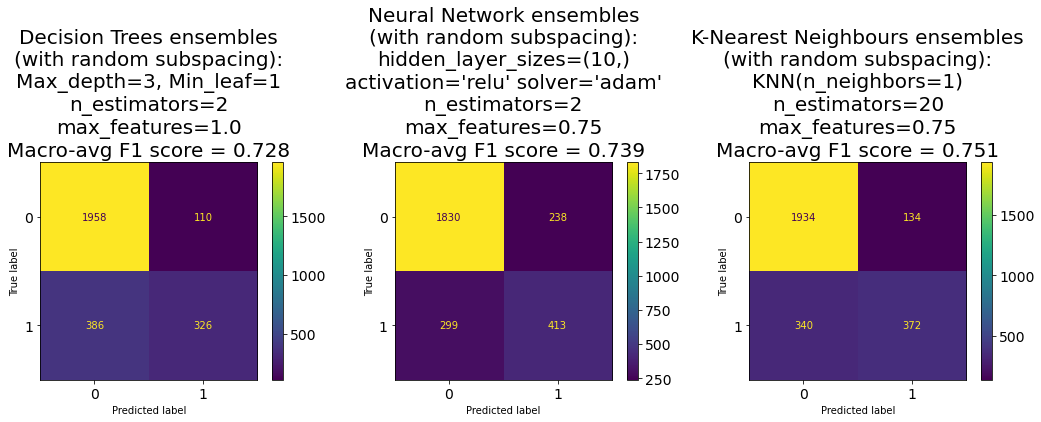

In [49]:
fig, ax = plt.subplots(1, 3, figsize=(18, 4))
ConfusionMatrixDisplay.from_estimator(best_dtcBag_randomSub, X_test, y_test, ax=ax[0])\
    .ax_.set_title("Decision Trees ensembles\n(with random subspacing):\nMax_depth=3, Min_leaf=1\nn_estimators={}\nmax_features={}\nMacro-avg F1 score = {:.3f}"
                   .format(best_dtcBag_randomSub.n_estimators, best_dtcBag_randomSub.max_features, full_result['dtc_bag_randomSub']))

ConfusionMatrixDisplay.from_estimator(best_mlpBag_randomSub, X_test, y_test, ax=ax[1])\
    .ax_.set_title("Neural Network ensembles\n(with random subspacing):\nhidden_layer_sizes=(10,)\nactivation=\'relu\' solver=\'adam\'\nn_estimators={}\nmax_features={}\nMacro-avg F1 score = {:.3f}"
                   .format(best_mlpBag_randomSub.n_estimators, best_mlpBag_randomSub.max_features, full_result['mlp_bag_randomSub']))

ConfusionMatrixDisplay.from_estimator(best_knnBag_randomSub, X_test, y_test, ax=ax[2])\
    .ax_.set_title("K-Nearest Neighbours ensembles\n(with random subspacing):\nKNN(n_neighbors=1)\nn_estimators={}\nmax_features={}\nMacro-avg F1 score = {:.3f}"
                   .format(best_knnBag_randomSub.n_estimators, best_knnBag_randomSub.max_features, full_result['knn_bag_randomSub']))
clear_output()
plt.show();

<br/>**Insight**

Similarly, we combined the three classifiers, but this time using a random subspacing approach. Despite some variation in the results, the KNN is still the best classifier. We can see from the above that it scored 0.751, followed by the neural network with 0.739. This time the decision tree scored the lowest with 0.728.

## **Question 1e** 
**Based on the lectures, which set of classifiers is expected to benefit more from bagging techniques than random subspacing and which classifiers benefit more from random subspacing? For your dataset, determine the best ensemble strategy for each of these classifiers. Discuss if this is in line with what you expected. Discuss if there is enough diversity in your ensemble and what else could you have done to improve the performance of your ensemble. [15 marks]**

<br/>**Insight**<br/>

Normally, we believe that bagging methods encourage diversity in the ensemble and work better for 'unstable' classifiers, for example, decision trees and neural networks. The experimental results are somewhat consistent with what we would expect. The result of **decision trees** bagging is a significant improvement although the random subspacing does not show a distinct change. The most unexpected was the **neural network**, which decreased rather than improved the results of bagging in our experimental dataset. The use of random subspacing technique can result in better performance, but it is still not as good as the normal model. **k nearest neighbour** is the classifier that gets more benefit from the ensemble. In this case, the KNN classifier gains more from the random subspacing than the bagging technique.

| Classifers| Best score for basic classifier <br/> (Q1-b) | Best score for ensembles with bagging <br/> (Q1-c) | Improve? | Best score for ensembles with random subspacing <br/> (Q1-d) | Improve? 
|:-:|:-:|:-:|:-:|:-:|:-:
|  Decision Trees | 0.708 | 0.738 | Yes | 0.728 | No, but better than ordinary
|  Neural Network | 0.748 | 0.726 | No | 0.739 | Yes, but not as good as ordinary
|  k Nearest Neighbour | 0.691 | 0.739 | Yes | 0.751 | Yes

I believe that there is a lack of sufficient diversity in this ensemble. Diversity is very important in collections, because the probability of a majority of voters being correct will increase as the ensemble grows only if the diversity in the ensemble continues to grow as well. To improve ensemble performance, we may consider using more estimators for bagging and random subspacing. In addition, when constructing an ensemble of classifiers, we need to balance diversity against accuracy (trade-off).

# **Question 2** 
**You are given a set of 10 balls and 10 bins (numbered 0 to 9). Initially, all the balls are in the bin number 5 and your goal is to ensure that the balls are well distributed across the bins eventually. Ideally, all balls should be in different bins. Train a reinforcement learning (RL) agent that should consider all balls in turn and for each ball $\mathcal{b}$, decide whether to keep the ball in the current bin $\mathscr{B}\mathcal{b}$, move it to the bin $\mathscr{B}\mathcal{b} - 1$ or move it to the bin $\mathscr{B}\mathcal{b} + 1$. Note that the action to move to bin $\mathscr{B}\mathcal{b} - 1$ is only permissible if $\mathscr{B}\mathcal{b} - 1 ≥ 0$ and the action to move it to the bin $\mathscr{B}\mathcal{b} + 1$ is only permissible if $\mathscr{B}\mathcal{b} + 1 ≤ 9$.**

## **Question 2a** 
**Carefully decide the features to use in the state representation of your RL agent. Also, carefully decide the reward function for your RL agent and the length of an episode. Note that you can also have contextual features in your state representation, i.e., features that are specific to the ball with the current turn. [10 marks]**

- We need **three actions** to represent how balls move: 
        1. LEFT: move ball to the left.
        2. RIGHT: move ball to the right.
        3. STAY: keep the ball in place.


- A list of **bins** is required to represent the number of balls each bin.

- **ball_pos** is used to track current ball's position.

**Initial:**<br/>
We set all balls in the NO.5 bin and initial `ball_pos` to 5. Since there are three actions, set `action_space` to 3. The observation will be the position of the ball and action of the agent, therefore, we set `observation_space` to [10,3].

**Reset:**<br/>
When the episode finish, we need to reset the whole environment for the next round, we reset `bins`, `ball_pos` and `observation`.

**Step:**<br/>
First, we will try to match the actions the agent made.

1) When it wants to **move left**:
- First check if current ball is already in the left most position (handle boundary problem).
- If not, check that the adjacent left box is empty, or that all left boxes have fewer balls.
- If so we can move ball to the left.
- For the **reward**, if all the empty boxes on the left are more than those on the right, award `20`, otherwise, only reward `15`.

2) When it wants to **move right**:
- This is similar to the previous one, except that the left and right are opposite.

3) When it wants to **stay**:
- If the ball is already on the boundary (left or right) and it needs to stop, award `10`.
- Otherwise, if it has only one ball in the left (right) bin and there are no other free bins in the left (right), award `10` as well.

After this we need to check that there is one and **only** one ball in the bin where the ball has been moved. If so, **reposition** 'ball_pos' to `bin 5`.

Finally, we check that the bins are in line with the winning situation.

**Render:**<br/>
We use render to visualise the environment.

## **Question 2b** 
**Implement how the agent interacts with the environment (i.e., the step function, restart function, init function etc.) [10 marks]**

In [50]:
class CustomEnv(gym.Env):
    metadata = {'render.modes': ['console']}
    
    # Define constants for actions
    LEFT  = 0
    RIGHT = 1
    STAY  = 2
    
    def __init__(self):
        super(CustomEnv, self).__init__()

        self.bins  = [0,0,0,0,0,10,0,0,0,0]
        self.ball_pos = 5
        
        # Define action and observation space
        # Example when using discrete actions, we have three: left and right and stay
        self.action_space = spaces.Discrete(3)
        # The observation will be the position and action of the agent.
        self.observation_space = spaces.MultiDiscrete([10,3])

    def reset(self):
        self.bins  = [0,0,0,0,0,10,0,0,0,0]
        self.ball_pos = 5
        observation = np.array([self.ball_pos,1])
        return observation

    def step(self, action):
        reward = 0
        done = False
        
        if action == self.LEFT:
            if self.ball_pos != 0:
                if (self.bins[self.ball_pos-1] == 0) | \
                    (sum(self.bins[:self.ball_pos]) < self.ball_pos):
                    if self.bins[:self.ball_pos].count(0) > self.bins[self.ball_pos+1:].count(0):
                        reward = 20
                    else:
                        reward = 15
                    self.bins[self.ball_pos] -= 1
                    self.ball_pos -= 1
                    self.bins[self.ball_pos] += 1
                    
        elif action == self.RIGHT:
            if self.ball_pos != 9:
                if (self.bins[self.ball_pos+1] == 0) | \
                    (sum(self.bins[self.ball_pos+1:]) < self.ball_pos-1):
                    if self.bins[:self.ball_pos].count(0) < self.bins[self.ball_pos+1:].count(0):
                        reward = 20
                    else:
                        reward = 15
                    self.bins[self.ball_pos] -= 1
                    self.ball_pos += 1
                    self.bins[self.ball_pos] += 1
        
        elif action == self.STAY:
            if (self.ball_pos == 0) | (self.ball_pos == 9):
                reward = 10
            elif ((self.bins[self.ball_pos-1] == 1) & (sum(self.bins[:self.ball_pos]) == self.ball_pos)) |\
                 ((self.bins[self.ball_pos+1] == 1) & (sum(self.bins[self.ball_pos+1:]) == self.ball_pos-1)):
                reward = 10
        else:
            raise ValueError("Received invalid action={} which is not part of the action space".format(action))
        
        # Check that there is one and only one ball in the bin where the ball has been moved. 
        # If so, reposition 'ball_pos' to bin 5.
        if self.bins[self.ball_pos] == 1:
            self.ball_pos = 5
        
        # Finish?
        if self.bins == [1,1,1,1,1,1,1,1,1,1]:
            done = True
            reward = 100
            print("********************* Finish *********************")

        # Optionally we can pass additional info, we are not using that for now
        observation = np.array([self.ball_pos,action])
        info = {}
        
        return observation, reward, done, info

    def render(self, mode='human'):
        print("So far, the bins is {} ".format(self.bins))
        print("Current in pos: {}".format(self.ball_pos))
        max_ = max(self.bins)
        count = max_
        for i in range(max_):
            if i == max_-1:
                s = ''
                for n in self.bins:
                    if n < count:
                        s += '| |'
                    else:
                        s += '|o|'
                count -= 1
                print(s)
            else:
                s = ''
                for n in self.bins:
                    if n < count:
                        s += '   '
                    else:
                        s += ' o '
                count -= 1
                print(s)
        print('```' * 10)
        print("\n")
    def close(self):
        pass

In [56]:
env = CustomEnv()
print(env.observation_space)

# If the environment don't follow the interface, an error will be thrown
check_env(env, warn=True)

MultiDiscrete([10  3])


In [57]:
start_time = time.time()
# Train the agent
model = PPO('MlpPolicy', env, verbose=1).learn(50000)
finish_time = time.time()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
********************* Finish *********************
********************* Finish *********************
********************* Finish *********************
********************* Finish *********************
********************* Finish *********************
********************* Finish *********************
********************* Finish *********************
********************* Finish *********************
********************* Finish *********************
********************* Finish *********************
********************* Finish *********************
********************* Finish *********************
********************* Finish *********************
********************* Finish *********************
********************* Finish *********************
********************* Finish *********************
********************* Finish *********************
********************* Finish **********

In [58]:
# Test the trained agent
obs = env.reset()
#env.render()
step = 0
for i in range(50):
    action, _ = model.predict(obs, deterministic=True)
    print("Step {}".format(step + 1))
    print("Action: ", action)
    obs, reward, done, info = env.step(action)
    print('obs=', obs, 'reward=', reward, 'done=', done)
    env.render(mode='console')
    if done:
        # Note that the VecEnv resets automatically
        # when a done signal is encountered
        print("Goal reached!", "reward=", reward)
        break
    step+=1

Step 1
Action:  0
obs= [5 0] reward= 20 done= False
So far, the bins is [0, 0, 0, 0, 1, 9, 0, 0, 0, 0] 
Current in pos: 5
                o             
                o             
                o             
                o             
                o             
                o             
                o             
                o             
| || || || ||o||o|| || || || |
``````````````````````````````


Step 2
Action:  1
obs= [5 1] reward= 15 done= False
So far, the bins is [0, 0, 0, 0, 1, 8, 1, 0, 0, 0] 
Current in pos: 5
                o             
                o             
                o             
                o             
                o             
                o             
                o             
| || || || ||o||o||o|| || || |
``````````````````````````````


Step 3
Action:  0
obs= [4 0] reward= 20 done= False
So far, the bins is [0, 0, 0, 0, 2, 7, 1, 0, 0, 0] 
Current in pos: 4
                o             
          

## **Question 2c** 
**Compare the RL strategies PPO, DQN and A2C for this problem. Are they able to learn a consistent winning policy after (i) 50,000 episodes, (ii) 100,000 episodes and (iii) 200,000 episodes? Which policy learns the strategy quickest? Why do you think this is the case? [10 marks]**

### **PPO**
#### (i) **50,000** episodes (~41s)

In [59]:
runtime = {}
runtime['PPO 50,000 eps'] = finish_time - start_time
print("PPO learn 50,000 episodes runtime: {} seconds.".format(round(runtime['PPO 50,000 eps'], 2)))

PPO learn 50,000 episodes runtime: 40.55 seconds.


In [60]:
# Evaluate the policy
mean_reward, std_reward = evaluate_policy(model.policy, model.get_env(), n_eval_episodes=100, deterministic=True)
clear_output()
print(f"mean_reward={mean_reward:.2f} +/- {std_reward}")

mean_reward=530.00 +/- 0.0


#### (ii) **100,000** episodes (~80s)

In [61]:
# Train the agent
start_time = time.time()
model_PPO_100k = PPO('MlpPolicy', env, verbose=1).learn(100000)
finish_time = time.time()
clear_output()

In [62]:
runtime['PPO 100,000 eps'] = finish_time - start_time
print("PPO learn 100,000 episodes runtime: {} seconds.".format(round(runtime['PPO 100,000 eps'], 2)))

PPO learn 100,000 episodes runtime: 80.0 seconds.


#### (iii) **200,000** episodes (~153s)

In [63]:
# Train the agent
start_time = time.time()
model_PPO_200k = PPO('MlpPolicy', env, verbose=1).learn(200000)
finish_time = time.time()
clear_output()

In [64]:
runtime['PPO 200,000 eps'] = finish_time - start_time
print("PPO learn 200,000 episodes runtime: {} seconds.".format(round(runtime['PPO 200,000 eps'], 2)))

PPO learn 200,000 episodes runtime: 152.64 seconds.


### **DQN**
#### (i) **50,000** episodes (~6s)

In [65]:
# Train the agent
start_time = time.time()
model_DQN_50k = DQN('MlpPolicy', env, verbose=1).learn(50000)
finish_time = time.time()
clear_output()

In [66]:
runtime['DQN 50,000 eps'] = finish_time - start_time
print("DQN learn 50,000 episodes runtime: {} seconds.".format(round(runtime['DQN 50,000 eps'], 2)))

DQN learn 50,000 episodes runtime: 5.55 seconds.


#### (ii) **100,000** episodes (~42s)

In [67]:
# Train the agent
start_time = time.time()
model_DQN_100k = DQN('MlpPolicy', env, verbose=1).learn(100000)
finish_time = time.time()
clear_output()

In [68]:
runtime['DQN 100,000 eps'] = finish_time - start_time
print("DQN learn 100,000 episodes runtime: {} seconds.".format(round(runtime['DQN 100,000 eps'], 2)))

DQN learn 100,000 episodes runtime: 42.01 seconds.


#### (iii) **200,000** episodes (~110s)

In [69]:
# Train the agent
start_time = time.time()
model_DQN_200k = DQN('MlpPolicy', env, verbose=1).learn(200000)
finish_time = time.time()
clear_output()

In [70]:
runtime['DQN 200,000 eps'] = finish_time - start_time
print("DQN learn 200,000 episodes runtime: {} seconds.".format(round(runtime['DQN 200,000 eps'], 2)))

DQN learn 200,000 episodes runtime: 109.7 seconds.


### **A2C**
#### (i) **50,000** episodes (~49s)

In [71]:
# Train the agent
start_time = time.time()
model_A2C_50k = A2C('MlpPolicy', env, verbose=1).learn(50000)
finish_time = time.time()
clear_output()

In [72]:
runtime['A2C 50,000 eps'] = finish_time - start_time
print("A2C learn 50,000 episodes runtime: {} seconds.".format(round(runtime['A2C 50,000 eps'], 2)))

A2C learn 50,000 episodes runtime: 48.98 seconds.


#### (ii) **100,000** episodes (~94s)

In [73]:
# Train the agent
start_time = time.time()
model_A2C_100k = A2C('MlpPolicy', env, verbose=1).learn(100000)
finish_time = time.time()
clear_output()

In [74]:
runtime['A2C 100,000 eps'] = finish_time - start_time
print("A2C learn 100,000 episodes runtime: {} seconds.".format(round(runtime['A2C 100,000 eps'], 2)))

A2C learn 100,000 episodes runtime: 93.64 seconds.


#### (iii) **200,000** episodes (~190s)

In [75]:
# Train the agent
start_time = time.time()
model_A2C_200k = A2C('MlpPolicy', env, verbose=1).learn(200000)
finish_time = time.time()
clear_output()

In [76]:
runtime['A2C 200,000 eps'] = finish_time - start_time
print("A2C learn 200,000 episodes runtime: {} seconds.".format(round(runtime['A2C 200,000 eps'], 2)))

A2C learn 200,000 episodes runtime: 189.91 seconds.


### **Comparison**

In [78]:
# for i,v in runtime.items():
#     print("{} runtime: {} seconds.".format(i,round(v,2)))

| Run times| 50,000 eps | 100,000 eps | 200,000 eps 
|:-:|:-:|:-:|:-:|
|  **PPO** | 40.55 | 80.0 | 152.64 
|  **DQN** | 5.55 | 42.01 | 109.7 
|  **A2C** | 48.98 | 93.64 | 189.91

From the table above we can see that they are still able to learn a consistent winning strategy after 50,000  episodes, 100,000  episodes or even 200,000  episodes, but among them **DQN is the best performer** and it is the fastest learning method in all respects. Because it is based on Q network use off-policy method and slow convergence but efficiency is high. It was followed by the PPO method which is an on-policy algorithm. The slowest learner was A2C, it is an off-policy method and uses advantage estimates to calculate the value proposition for each action state pair.

## **Question 2d** 
**For the best RL strategy, start with a neural network architecture consisting of 3 hidden layers of 64 neurons each and gradually decrease the number of neurons and number of layers. What is the minimal architecture that still allows you to successfully learn a winning strategy? For example, can you learn a winning strategy with a single hidden layer of 2 neurons? Why do you think this is the case? [10 marks]**

### 3 hidden layers of 64 neurons

In [79]:
env = CustomEnv()
check_env(env, warn=True)

# getting the shape of our observation space and the number of actions
states = env.observation_space.shape[0]
actions = env.action_space.n

# building the model
model = Sequential()    
model.add(Dense(64, activation='relu', input_shape = (1,states)))
model.add(Dense(64, activation='relu'))
model.add(Dense(actions, activation='linear'))
model.add(Flatten()) 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1, 64)             192       
                                                                 
 dense_1 (Dense)             (None, 1, 64)             4160      
                                                                 
 dense_2 (Dense)             (None, 1, 3)              195       
                                                                 
 flatten (Flatten)           (None, 3)                 0         
                                                                 
Total params: 4,547
Trainable params: 4,547
Non-trainable params: 0
_________________________________________________________________


 Building the agent then compile

In [80]:
memory = SequentialMemory(limit=50000, window_length=1)
policy = BoltzmannQPolicy()

In [82]:
# building the agent
dqn = DQNAgent(model=model, memory=memory, policy=policy, nb_actions=actions, \
               nb_steps_warmup=10, target_model_update=1e-2)

dqn.compile(Adam(lr=1e-3), metrics=['mae'])
dqn.fit(env, nb_steps=5000, visualize=False, verbose=1)

Training for 5000 steps ...
Interval 1 (0 steps performed)
 4990/10000 [=============>................] - ETA: 22s - reward: 11.1653done, took 22.520 seconds


### 3 hidden layers of 16 neurons

In [83]:
env = CustomEnv()
check_env(env, warn=True)

# getting the shape of our observation space and the number of actions
states = env.observation_space.shape[0]
actions = env.action_space.n

# building the model
model = Sequential()    
model.add(Dense(16, activation='relu', input_shape = (1,states)))
model.add(Dense(16, activation='relu'))
model.add(Dense(actions, activation='linear'))
model.add(Flatten()) 
model.summary()

# building the agent
dqn = DQNAgent(model=model, memory=memory, policy=policy, nb_actions=actions, \
               nb_steps_warmup=10, target_model_update=1e-2)

dqn.compile(Adam(lr=1e-3), metrics=['mae'])
dqn.fit(env, nb_steps=5000, visualize=False, verbose=1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1, 16)             48        
                                                                 
 dense_4 (Dense)             (None, 1, 16)             272       
                                                                 
 dense_5 (Dense)             (None, 1, 3)              51        
                                                                 
 flatten_1 (Flatten)         (None, 3)                 0         
                                                                 
Total params: 371
Trainable params: 371
Non-trainable params: 0
_________________________________________________________________
Training for 5000 steps ...
Interval 1 (0 steps performed)
 4992/10000 [=============>................] - ETA: 24s - reward: 8.0168done, took 24.710 seconds


### 3 hidden layers of 3 neurons

In [84]:
env = CustomEnv()
check_env(env, warn=True)

# getting the shape of our observation space and the number of actions
states = env.observation_space.shape[0]
actions = env.action_space.n

# building the model
model = Sequential()    
model.add(Dense(3, activation='relu', input_shape = (1,states)))
model.add(Dense(3, activation='relu'))
model.add(Dense(actions, activation='linear'))
model.add(Flatten()) 
model.summary()

# building the agent
dqn = DQNAgent(model=model, memory=memory, policy=policy, nb_actions=actions, \
               nb_steps_warmup=10, target_model_update=1e-2)

dqn.compile(Adam(lr=1e-3), metrics=['mae'])
dqn.fit(env, nb_steps=5000, visualize=False, verbose=1)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1, 3)              9         
                                                                 
 dense_7 (Dense)             (None, 1, 3)              12        
                                                                 
 dense_8 (Dense)             (None, 1, 3)              12        
                                                                 
 flatten_2 (Flatten)         (None, 3)                 0         
                                                                 
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________
Training for 5000 steps ...
Interval 1 (0 steps performed)
 4992/10000 [=============>................] - ETA: 23s - reward: 3.6218done, took 24.035 seconds


### 2 hidden layers of 64 neurons

In [85]:
env = CustomEnv()
check_env(env, warn=True)

# getting the shape of our observation space and the number of actions
states = env.observation_space.shape[0]
actions = env.action_space.n

# building the model
model = Sequential()    
model.add(Dense(64, activation='relu', input_shape = (1,states)))
model.add(Dense(actions, activation='linear'))
model.add(Flatten()) 
model.summary()

# building the agent
dqn = DQNAgent(model=model, memory=memory, policy=policy, nb_actions=actions, \
               nb_steps_warmup=10, target_model_update=1e-2)

dqn.compile(Adam(lr=1e-3), metrics=['mae'])
dqn.fit(env, nb_steps=5000, visualize=False, verbose=1)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 1, 64)             192       
                                                                 
 dense_10 (Dense)            (None, 1, 3)              195       
                                                                 
 flatten_3 (Flatten)         (None, 3)                 0         
                                                                 
Total params: 387
Trainable params: 387
Non-trainable params: 0
_________________________________________________________________
Training for 5000 steps ...
Interval 1 (0 steps performed)
 4993/10000 [=============>................] - ETA: 25s - reward: 10.7490done, took 25.917 seconds


### 2 hidden layers of 16 neurons 

In [86]:
env = CustomEnv()
check_env(env, warn=True)

# getting the shape of our observation space and the number of actions
states = env.observation_space.shape[0]
actions = env.action_space.n

# building the model
model = Sequential()    
model.add(Dense(16, activation='relu', input_shape = (1,states)))
model.add(Dense(actions, activation='linear'))
model.add(Flatten()) 
model.summary()

# building the agent
dqn = DQNAgent(model=model, memory=memory, policy=policy, nb_actions=actions, \
               nb_steps_warmup=10, target_model_update=1e-2)

dqn.compile(Adam(lr=1e-3), metrics=['mae'])
dqn.fit(env, nb_steps=5000, visualize=False, verbose=1)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 1, 16)             48        
                                                                 
 dense_12 (Dense)            (None, 1, 3)              51        
                                                                 
 flatten_4 (Flatten)         (None, 3)                 0         
                                                                 
Total params: 99
Trainable params: 99
Non-trainable params: 0
_________________________________________________________________
Training for 5000 steps ...
Interval 1 (0 steps performed)
 4990/10000 [=============>................] - ETA: 25s - reward: 8.7866done, took 25.334 seconds


### 2 hidden layers of 3 neurons each

In [87]:
env = CustomEnv()
check_env(env, warn=True)

# getting the shape of our observation space and the number of actions
states = env.observation_space.shape[0]
actions = env.action_space.n

# building the model
model = Sequential()    
model.add(Dense(3, activation='relu', input_shape = (1,states)))
model.add(Dense(actions, activation='linear'))
model.add(Flatten()) 
model.summary()

# building the agent
dqn = DQNAgent(model=model, memory=memory, policy=policy, nb_actions=actions, \
               nb_steps_warmup=10, target_model_update=1e-2)

dqn.compile(Adam(lr=1e-3), metrics=['mae'])
dqn.fit(env, nb_steps=5000, visualize=False, verbose=1)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 1, 3)              9         
                                                                 
 dense_14 (Dense)            (None, 1, 3)              12        
                                                                 
 flatten_5 (Flatten)         (None, 3)                 0         
                                                                 
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________
Training for 5000 steps ...
Interval 1 (0 steps performed)
 5000/10000 [==============>...............] - ETA: 25s - reward: 6.1960done, took 25.867 seconds


### 1 hidden layers of 3 neurons each

In [88]:
env = CustomEnv()
check_env(env, warn=True)

# getting the shape of our observation space and the number of actions
states = env.observation_space.shape[0]
actions = env.action_space.n

# building the model
model = Sequential()    
model.add(Dense(3, activation='relu', input_shape = (1,states)))
model.add(Flatten()) 
model.summary()

# building the agent
dqn = DQNAgent(model=model, memory=memory, policy=policy, nb_actions=actions, \
               nb_steps_warmup=10, target_model_update=1e-2)

dqn.compile(Adam(lr=1e-3), metrics=['mae'])
dqn.fit(env, nb_steps=5000, visualize=False, verbose=1)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 1, 3)              9         
                                                                 
 flatten_6 (Flatten)         (None, 3)                 0         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Training for 5000 steps ...
Interval 1 (0 steps performed)
 4991/10000 [=============>................] - ETA: 27s - reward: 9.1745done, took 28.041 seconds


As we can see from the above experiments, a minimum of `one hidden layer and three neurons` is required for the neural network to successfully learn the winning strategy. This may be because the environment for this problem is relatively simple and does not require too much computational complexity, so very small neural network architectures can be used to solve the problem.

## **Question 2e** 
**Compare the effect of different state representations and different reward functions on the ability of the RL agent to learn a winning strategy quickly. [10 marks]**

The process is omitted here and the results are as follows:

||Finish: 100 <br/> Left: 20 and 15<br/> Right: 20 and 15 <br/>Stay: 10<br/>After 50k eps in PPO|Finish: 100 <br/> Left: 20 and 15<br/> Right: 20 and 15 <br/>Stay: 10<br/>After 100k eps in PPO|Finish: 500 <br/> Left: 300 and 200<br/> Right: 300 and 200 <br/>Stay: 100<br/>After 50k eps in PPO | Finish: 500 <br/> Left: 300 and 200<br/> Right: 300 and 200 <br/>Stay: 100<br/>After 100k eps in PPO
|:-:|:-:|:-:|:-:|:-:| 
| **rollout/**                | | |               |              |
|    ep_len_mean          | 29.6| 109| 44.5        |37.2          |
|    ep_rew_mean          | 533| 1.24e+03| 6.71e+03      |6.6e+03       |
| **time/**                  | | |               |              |
|    fps                  | 1150| 1201 | 1177         | 1341         
|    iterations           | 25| 49| 25            |49           |
|    time_elapsed         | 44| 83| 43            | 74           |
|    total_timesteps      | 51200| 100352| 51200        | 100352       |
| **train/**                 | | |              |              |  
|    approx_kl            | 0.0024244532| 0.0023405133| 0.00024393134 | 0.0004722143 |
|    clip_fraction        | 0.0237| 0.0428| 0             | 0            |
|    clip_range           | 0.2| 0.2| 0.2           | 0.2          |
|    entropy_loss         |  -0.501| -0.299| -0.969        | -0.829       |
|    explained_variance   | 2.86e-06| 0.000378| 1.79e-07      | 0            |
|    learning_rate        | 0.0003| 0.0003| 0.0003        | 0.0003       |
|    loss                 | 5.63e+03| 5.16e+03| 1.55e+06      | 1.63e+06     |
|    n_updates            | 240| 480| 240           | 480          |
|    policy_gradient_loss | -0.00372| -0.00661| -0.00107      | -0.00108     |
|    value_loss           | 1.31e+04 | 1.06e+04 | 2.81e+06      | 3.3e+06      |
|     ***Reset and predict***   | Yes | Yes | N/A | N/A|

As we can see above, When we adjust the reward score upwards, the interval becomes larger. This can have an effect on the learning efficiency of the agent. Interestingly, when the reward is small, it is good for short term learning and it gives very good solutions in the 50k eps, however when the number of learning eps increases, it becomes worse instead. But this method all yields good predictions. In contrast when the reward is high, the longer the learning time, the better it will be. However, this method is not successful in predicting solutions in the short term. Therefore, we found that a good state representation and reward function have a significant impact on the ability of RL agents to learn winning strategies quickly. 